In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics

# Description of Classification methods 

## Unsupervised Classification method: k-Means Clustering

As is common for all unsupervised Classification methods, k-Means seeks to discover unknown subgroups or structures in our data. In k-Means one seeks to separate the data into a pre-defined number of clusters (K) and the aim is to partition our datapoints into K clusters so that we minimize the variation within each cluster, while each datapoint should only belong to one cluster. One can define within-cluster variation $W(C_k)$ in several ways, but squared Euclidian distance is commonly used and will be used in this coursework: <br>  

$$W(C_k)= \frac{1}{\mid{C_k}\mid} \sum_{i,i'\in C_k} \sum_{j=1}^p (x_{ij} - x_{i'j})^2 \: \: (1)$$  <br>

That is, we take the sum of all the pairwise squared Euclidian distances between all observations in the kth cluster, and divide it by the total number of observations in this cluster ($\mid{C_k}\mid$). This gives the variation within the kth cluster. k-Means seeks to minimize (1) across the k clusters: <br>

$$ minimize_{C_1,...,C_k} \bigg\{ \sum_{k=1}^KW(C_k) \bigg\} \: \: (2) $$  <br>

By performing the following algorithm we can then solve (2): <br>

 1. Specify k initial cluster centres (several strategies exists for to decide k). <br>
 2. Calculate the distance between each data point and each cluster centre, and let each datapoint belong to the cluster where it is closest to its centre. <br>
 3. For each new cluster calculate the new centre; the mean of all the features of the data points in the cluster (note that it is possible to use other metrics than the mean). <br>
 4. Iterate points 2-3 until the datapoints stop changing which cluster it belongs to.  <br>
<br>

The algorithm above only guarantees to find the local optimum and not a global optimum. Thus, one should run the algorithm several times with different initial centres, and then choose the best solution out of these (i.e. the one where (2) is the smallest). <br>

Also, the k-Means algorithm assumes that the data points in each cluster has a spherical distribution around the cluster centre and that each cluster has the same radius (i.e. variation) [1].<br>

## Supervised Classification method: K-Nearest Neighbors

If one has the conditional distributions of the class variable one wants to predict, one could use the Bayes classifier. However, when this is not the case one can choose a method which tries to estimate the conditional distribution of the dependant variable given the features in the dataset, and then allocate each observation to the class with the highest estimated probability. The K-Nearest Neighbors classifier is a method which does this. For each point $x_0$ and given a specified number K, it identifies the K closest datapoints to $x_0$ ( noted as $\mathcal{N_0}$ ) and estimates the conditional probability for $x_0$ belonging to class j: <br>

$$ Pr(Y = j \: | \: X=x_0) = \frac{1}{K}\sum_{i \in \mathcal{N_0}} I(y_i = j) \: \: (3) $$ <br>

Based on this the KNN algorithm will assign each observation to the class with the highest probability as given by (3). <br>

According to Witten & Hasie (2014) KNN can create classifiers which perform very close up to the performance the Bayes classifier, but is strongly dependant on the choice of number of neighbors (K) to consider to create the conditional distribution. Increasing K corresponds to reducing the flexibility of the method and thus smoothing the boundary between the classes. When K = 1 it will overfit as it will only consider each point as its own neighbor. It is thus important to consider the results from using different K-values on the test/validation dataset to choose a good value for K. Also, different distance metrics can be used, but Euclidian distance is very common and will be used in this coursework [1].

The k-Nearest Neighbor Algorithm is non-parametric, meaning that it does not assume that the underlying data takes a certain distribution.

# Exploratory Data Analysis

The data analysed here includes six different biomechanical features and a class label describing whether the person related to the observation had experienced any issues related to their spine (i.e. Disk Hernia or Spondylolisthesis) or not. The class Normal is for the observations without relation to spine issues, and Abnormal for those who had. <br>

Start out by doing EDA to understand the different features, the dependant variable and if any preprocessing or transformations of the data is necessary. <br>

In [3]:
# import data and name columns
df = pd.read_csv('vertebral_column_data.txt', sep=" ", header = None)
df.columns = ["pelvicIncidence", "pelvicTilt", "lumbarLordosis angle", 
              "sacralSlope", "pelvicRadius", "gradeSpondylolisthesis", 
              "patientClass" ]
df.head()

,pelvicIncidence,pelvicTilt,lumbarLordosis angle,sacralSlope,pelvicRadius,gradeSpondylolisthesis,patientClass
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB


In [4]:
#check number of observations 
df.shape

(310, 7)

In [5]:
#check for null values
df.isnull().sum().max()

0

In [6]:
#see statistics for numerical features
df.describe()

,pelvicIncidence,pelvicTilt,lumbarLordosis angle,sacralSlope,pelvicRadius,gradeSpondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000


In [7]:
#count how many are of each patient class: Normal or Abnormal
count_class = df['patientClass'].value_counts()
print(count_class)

AB    210
NO    100
Name: patientClass, dtype: int64


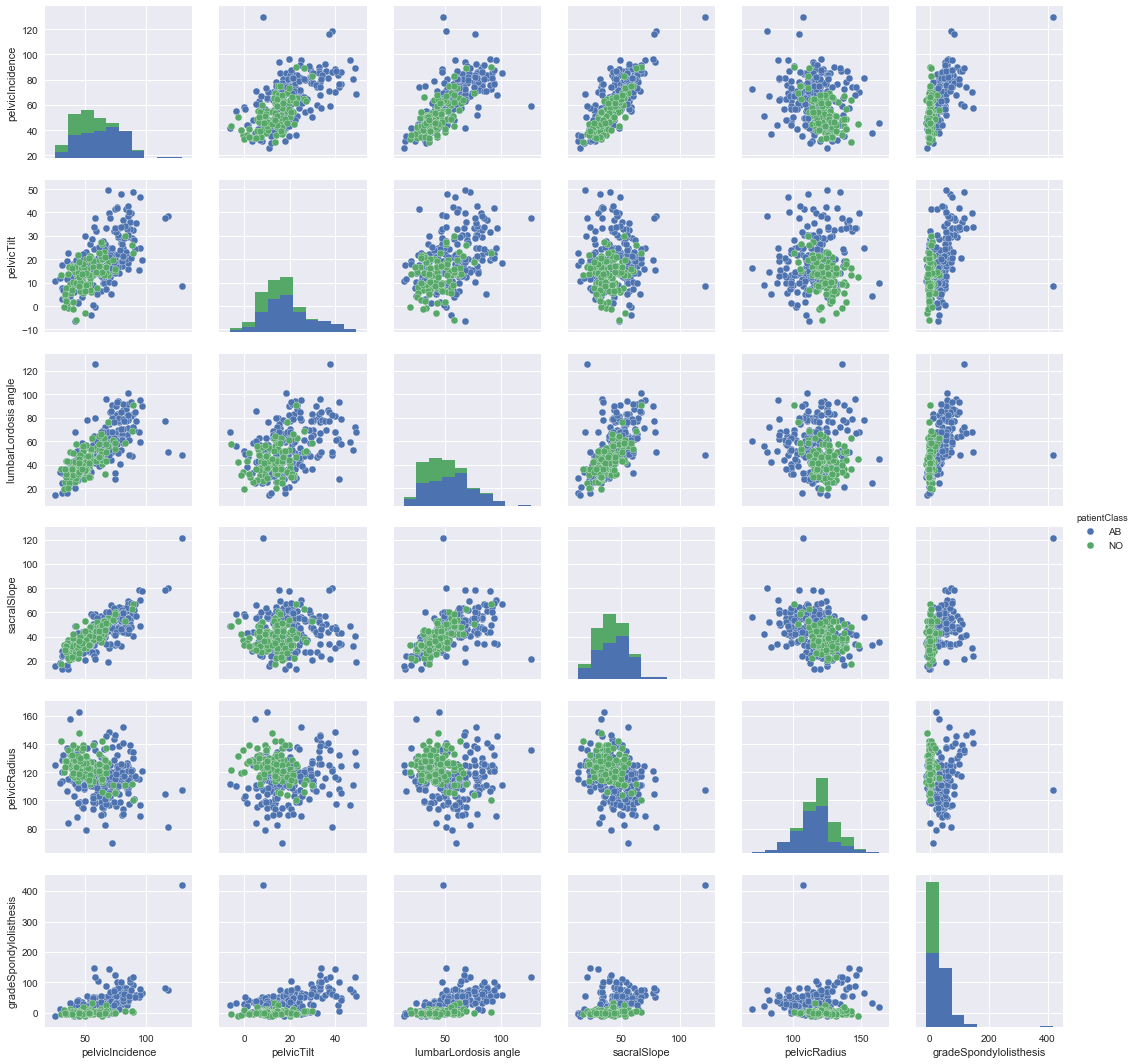

In [8]:
#create pairplot to investigate distributions
#differentiate between the patientClasses
sns.set()
sns.pairplot(df, hue = "patientClass")
plt.show()

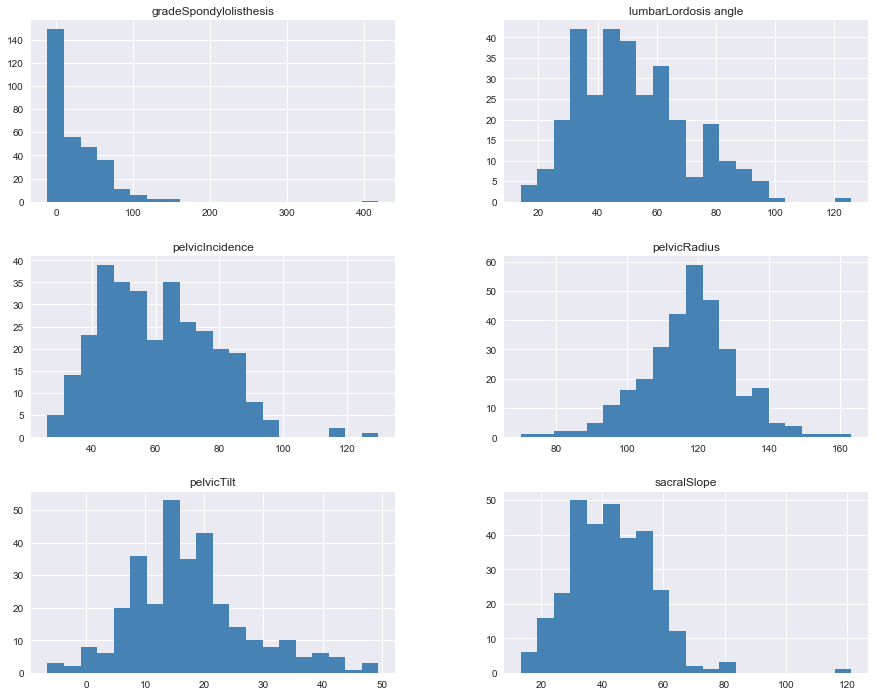

In [9]:
#create histograms to look at each features' distribution by itself
df.hist(figsize=(15,12),bins = 20, color="steelblue")
plt.show()

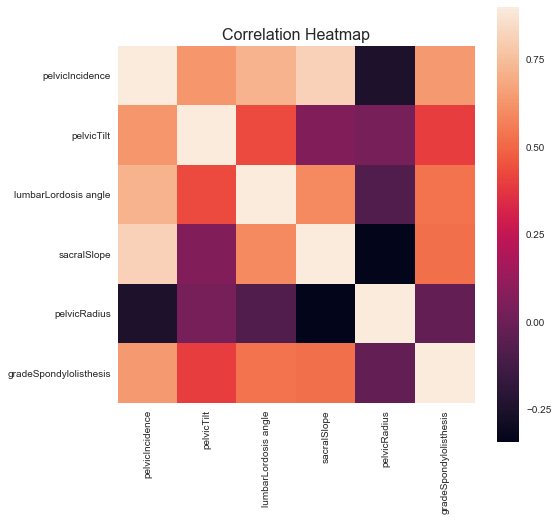

In [10]:
#check correlation with a heatmap
correlation = df.corr()
f , ax = plt.subplots(figsize = (8,8))
plt.title('Correlation Heatmap',y=1 ,size=16)
sns.heatmap(correlation, square = True, vmax=0.90)

Based on the EDA we have learned several things about our data, which can be used to decide which preprossecing and transformations are appropriate to be able to apply the models we introduced in the beginning of the report. Firstly, based on the statistics of the features and their distributions we saw that the variance differ across the features in the data and that it is not be evident whether the different features have the same or different scales. Secondly, based on the pairplot and the histograms we saw that the feature gradeSpondylolisthesis was rather skewed to the left and that the multivariate distributions indicate non-spherical shapes (several more elongated multivariate distributions). Thirdly, the pairplot and histogram show that there seems to be a few outliers. Lastly, we learned that there were no null values that have to be handled and that the correlation between the features vary.

# Preprocessing & Transformation

As the algorithms we are to apply make use of means and Euclidian distance in their computations, differing variance, scales and outliers will affect their results. This should thus be handled. Also, although KNN is non-parametric, K-Means is based on the assumption that the clusters are spherical with equal variance, which the data does not appear to be from the EDA. Based on this insight the following steps are taken to preprocess and transform the data: <br>

 1. Cube Root Transform of the feature gradeSpondylolisthesis to handle the left skew: As the feature has negative values we cannot make use of a log transform, thus a Cube Root transform is a recommended alternative [2]. <br>
 2. Remove outliers to avoid affecting mean measures: as the algorithms may be sensitive to outliers (for instance becauce k-Means use the mean when calculating new cluster centers) it can be beneficial to remove these. We make use of the Z-score (> 3) to do this, i.e. removing the datapoints who are beyond a certain distance from the mean [3].  <br>
 3. Standardize to handle different scales and variance. <br>

In [11]:
#as we will only transform the numerical values, we need to 
#specify the numerical columns
features = ["pelvicIncidence", "pelvicTilt", "lumbarLordosis angle", 
            "sacralSlope", "pelvicRadius", "gradeSpondylolisthesis"]

## Cube root transform

In [12]:
#use a cube root transform on gradeSpondylolisthesis to handle the skew 
df["gradeSpondylolisthesis"] = np.cbrt(df["gradeSpondylolisthesis"])

## Remove outliers

In [13]:
#remove outliers using z-score
df = df[(np.abs(stats.zscore(df.loc[:, features])) < 3).all(axis=1)]

In [14]:
#check how many observations were categorized as outliers (10)
df.shape

(300, 7)

## Standardize 

In [15]:
#standardize data (here we are missing the patientclass in the dff)
dff = pd.DataFrame(StandardScaler().fit_transform(df.loc[:, features]), 
                   columns = features)

In [16]:
#add patientClass to the dataframe again
dff["patientClass" ] = df["patientClass"]

## Evaluate data after preprocessing and transforms

In [17]:
#look at data
dff.head()

,pelvicIncidence,pelvicTilt,lumbarLordosis angle,sacralSlope,pelvicRadius,gradeSpondylolisthesis,patientClass
0,0.200537,0.577550,-0.659929,-0.177225,-1.542486,-1.354136,AB
1,-1.283402,-0.753487,-1.464142,-1.110317,-0.278840,-0.148927,AB
2,0.559605,0.542383,-0.082262,0.321020,-0.954818,-1.824300,AB
3,0.588701,0.801344,-0.400861,0.160899,-1.285582,0.156440,AB
4,-0.624080,-0.797180,-1.282243,-0.211363,-0.779802,0.027539,AB


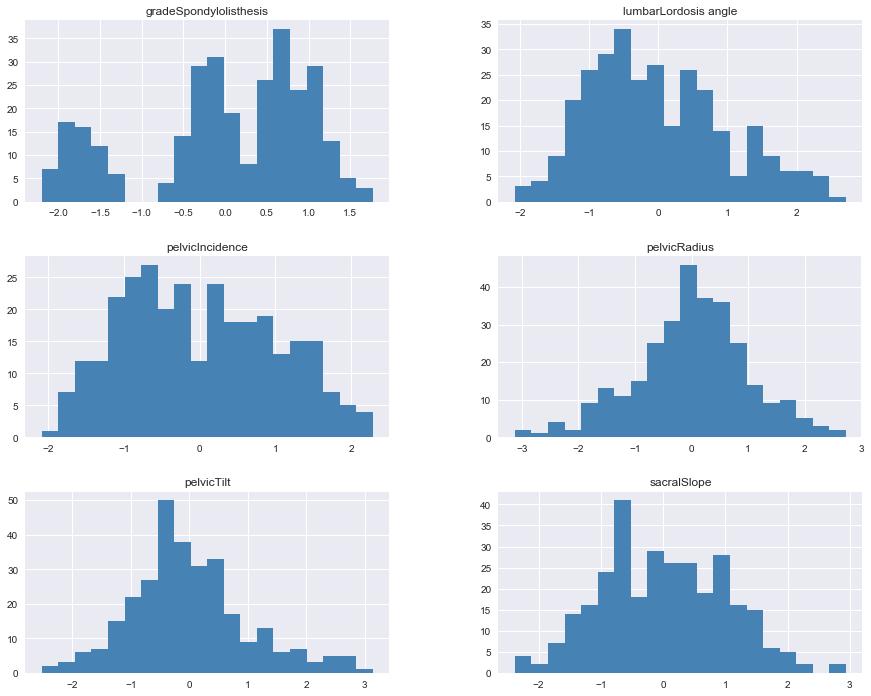

In [18]:
dff.hist(figsize=(15,12),bins = 20, color="steelblue")
plt.show()

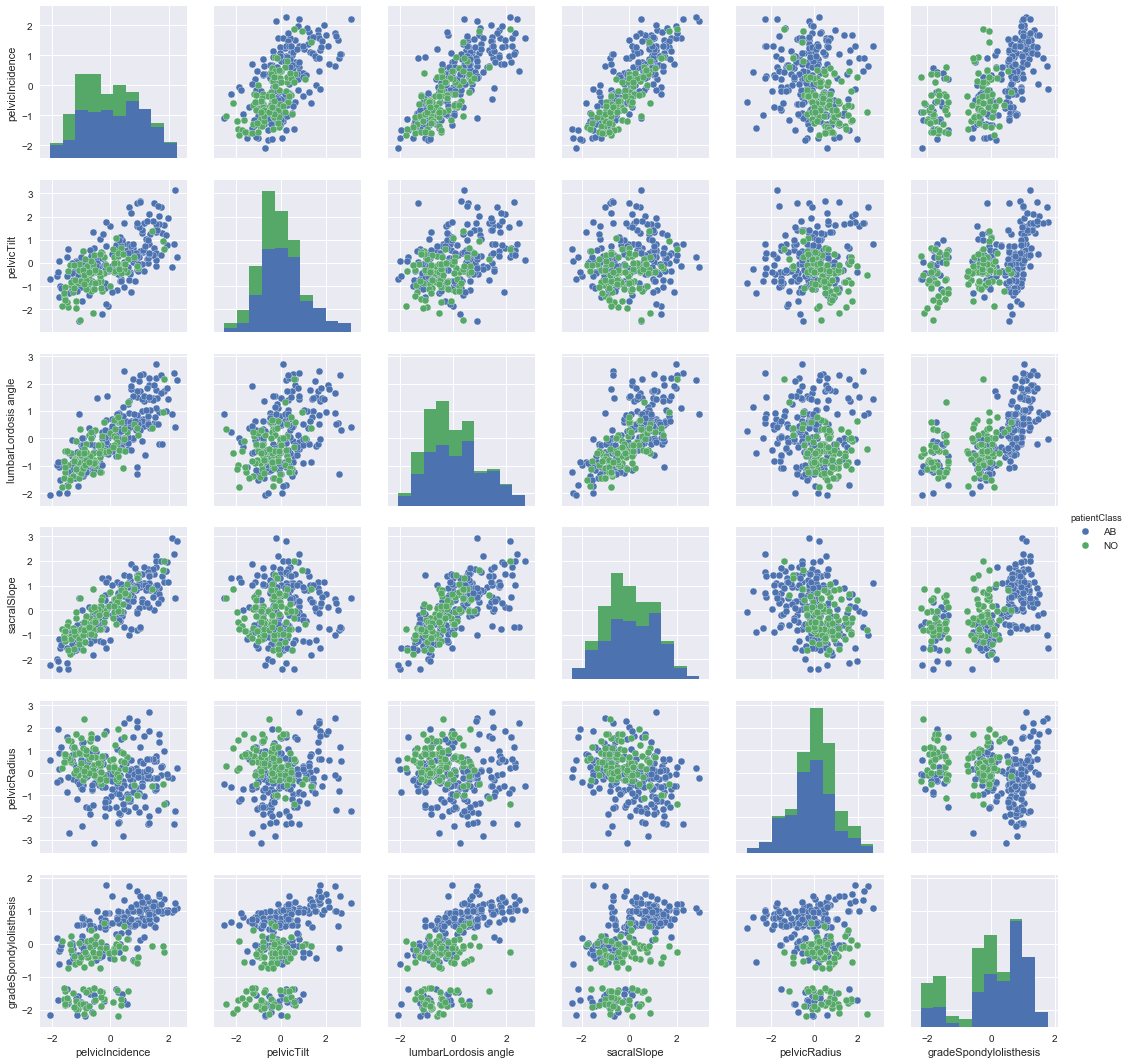

In [19]:
#create pairplot to investigate distribution after preprocessing and transforms
sns.set()
sns.pairplot(dff, hue = "patientClass")
plt.show()

After the preprocessing we can see that the feature gradeSpondylolisthesis is much less skewed than before. Moreover, the extent to which the multivariate distributions are elongated has been reduced - although still not completely spherical (which may affect the K-Means algorithms performance). Lastly, we can see that the outliers are gone (as there were only 10 it was considered ok to remove them). <br>

Before we apply the two classification algorithms we note that the pairplot above does not reveal any obvious clusters in the data. Several of the plots in the pairplot above do show that the green and blue dots are clustered slightly differently (slightly "dragged" in different directions), still they are largely overlapping in most of the plots. This makes it interesting to see how especially the k-Means algorithm will perform, as it is unsupervised and will have to "blindly" look for structure. <br> 

# Unsupervised Classification with k-Means: implementation and results

In the following section we will make use of the Scikit-learn library to apply the K-Means Classification algorithm on our data. The method provided by the library uses Euclidian distance as was used in the explanation above (other distance measures can also be used). Moreover, one can specify how many times to run the algorithm with different starting conditions to pick the best result, and the default value of 10 (n_init=10) is used below. The best result (lowest sum of squared distances within clusters) across the 10 runs is chosen by the method. Lastly, the implementation below make use of the default value for assigning initial cluster centres; init = kmeans++ [5]. <br>

We start out by evaluating how many clusters (K) we should specify for the algorithm to create. As we know that there are in fact two classes in the data we will compare the result of running the algorith with the suggested number K given by an elbow plot with the known number of classes (K=2) to compare the results. We will evaluate the results using appropriate measures as suggested in the documentation; Adjusted Rand Index and Mutual Information Score, in addition to confusion matrix for K=2. <br>

It is worth emphasizing that k-Means is usually applied to data without pre-known classes, and as such used to look for structure and subgroups which are not known. Still, it is interesting to compare to which extent it manages to cluster according to the classes that we already know, and make use of this when evaluating performance. <br>

## Deciding number of clusters: K

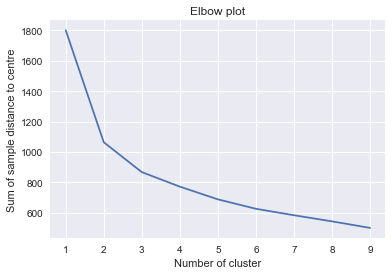

In [20]:
#create elbow plot to decide on appropriate number of clusters K
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dff.loc[:, features])
    sse[k] = kmeans.inertia_ 
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('Elbow plot')
plt.xlabel("Number of cluster")
plt.ylabel("Sum of sample distance to centre")
plt.show()

Based on the elbow plot above one can argue that it suggests that 3 is an appropriate number of clusters for the data, as this is the last point at which the line has a "clear" kink. Thus, we will compare the results from running the algorithm with both K=2 and K=3.

### k-Means with K=2

In [21]:
# do K-means with K = 2
x = dff.loc[:, features].values
km = KMeans(n_clusters=2)
km.fit(x)
km.predict(x)
labels = km.labels_

#add predicted labels to the dataframe
dff['KMlabels2'] = labels

In [22]:
#count classification compared to out original two classes
count_AB = dff[dff['patientClass']=="AB"]["KMlabels2"].value_counts()
count_NO = dff[dff['patientClass']=="NO"]["KMlabels2"].value_counts()
print("The observations belonging to the Abnormal class was classified as: \n", 
      count_AB.sort_index())
print("The observations belonging to the Normal class was classified as: \n", 
      count_NO.sort_index())

The observations belonging to the Abnormal class was classified as: 
 0    118
1     82
Name: KMlabels2, dtype: int64
The observations belonging to the Normal class was classified as: 
 0    19
1    71
Name: KMlabels2, dtype: int64


Based on the output above we can see which cluster which catches the most of each original class and use this further to see how well the algorithm managed to separate the two. We can interpret the allocation into the two classes as though the one with a majority of one patientClass in it - is in fact the "correct" class.

In [23]:
#create function translate categorical value to 0/1
def converter(cluster):
    if cluster=='AB':
        return 0
    else:
        return 1

In [24]:
#translate categorical class into 0/1
dff['Original_cluster'] = dff['patientClass'].apply(converter)
dff.head()

,pelvicIncidence,pelvicTilt,lumbarLordosis angle,sacralSlope,pelvicRadius,gradeSpondylolisthesis,patientClass,KMlabels2,Original_cluster
0,0.200537,0.577550,-0.659929,-0.177225,-1.542486,-1.354136,AB,1,0
1,-1.283402,-0.753487,-1.464142,-1.110317,-0.278840,-0.148927,AB,1,0
2,0.559605,0.542383,-0.082262,0.321020,-0.954818,-1.824300,AB,1,0
3,0.588701,0.801344,-0.400861,0.160899,-1.285582,0.156440,AB,0,0
4,-0.624080,-0.797180,-1.282243,-0.211363,-0.779802,0.027539,AB,1,0


In [25]:
labels_true = dff['Original_cluster'].values
labels_pred = dff["KMlabels2"].values

In [26]:
#find the proportion of correctly classified observations (Accuracy)
correct = 0
for i in range(len(labels_pred)):
    if labels_pred[i] == labels_true[i]:
        correct += 1

print(round(correct/len(labels_pred),3))

0.637


As we have two classes already present in the data (patientClass) we can make use of some of the evaluation measures suggested in the Scikit learn documentation which requires the "real" labels for the observations. Adjusted Rand Score (ARS) allows us to see to which extent the k_Means algorithm was able to cluster the observations into the known classes. The ARS measures similarity between the k-Means cluster allocation and the original classes. The result will give a number between 1 and -1, where a negative result or a result close to 0 indicates bad labeling [4].

In [27]:
#get ARS
round(metrics.adjusted_rand_score(labels_true, labels_pred),4)

0.0718

Another metric often used to evaluate clustering performance is Adjusted Mutual Information (AMI) which measures the agreement between two assignments, and the function provided by Scikit learn here also ignores permutations. A result close to 1 indicates perfect labeling, while results close to 0 indicate random cluster assignment [4]. 

In [28]:
#get AMI
round(metrics.adjusted_mutual_info_score(labels_true, labels_pred),4)

0.0655

For the purpose of comparison with KNN for later we also produce a confusion matrix and classification report for the results for K=2.

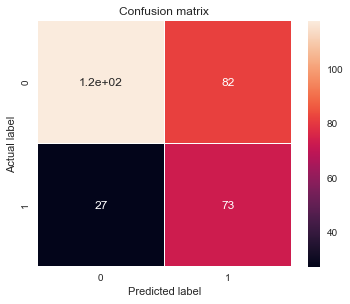

             precision    recall  f1-score   support

          0       0.81      0.59      0.68       200
          1       0.47      0.73      0.57       100

avg / total       0.70      0.64      0.65       300



In [29]:
confusionMatrix = confusion_matrix(labels_true,labels_pred)

plt.figure(figsize=(5,4))
sns.heatmap(confusionMatrix,annot=True,linewidths=.3)
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(labels_true,labels_pred))

### k-Means with K=3

In [30]:
# do K-means with K=3
x = dff.loc[:, features].values
km = KMeans(n_clusters=3)
km.fit(x)
km.predict(x)
labels = km.labels_
dff['KMlabels3'] = labels
dff.head()

,pelvicIncidence,pelvicTilt,lumbarLordosis angle,sacralSlope,pelvicRadius,gradeSpondylolisthesis,patientClass,KMlabels2,Original_cluster,KMlabels3
0,0.200537,0.577550,-0.659929,-0.177225,-1.542486,-1.354136,AB,1,0,0
1,-1.283402,-0.753487,-1.464142,-1.110317,-0.278840,-0.148927,AB,1,0,2
2,0.559605,0.542383,-0.082262,0.321020,-0.954818,-1.824300,AB,1,0,0
3,0.588701,0.801344,-0.400861,0.160899,-1.285582,0.156440,AB,0,0,0
4,-0.624080,-0.797180,-1.282243,-0.211363,-0.779802,0.027539,AB,1,0,2


In [31]:
#count classification (K=3) compared to out original two classes
count_AB = dff[dff['patientClass']=="AB"]["KMlabels3"].value_counts()
count_NO = dff[dff['patientClass']=="NO"]["KMlabels3"].value_counts()
print("The observations belonging to the Abnormal class was classified as: \n", 
      count_AB.sort_index())
print("The observations belonging to the Normal class was classified as: \n", 
      count_NO.sort_index())

The observations belonging to the Abnormal class was classified as: 
 0    74
1    59
2    67
Name: KMlabels3, dtype: int64
The observations belonging to the Normal class was classified as: 
 0    19
1     4
2    67
Name: KMlabels3, dtype: int64


From the results above it does not immediatly seem as if the k-Means algorithm managed to separate the two original classes into separate clusters. Cluster 1 seems to be the best, where it largely consists of Abnormal cases, and very few Normal ones. Cluster 2 contains 50-50 of the two original classes. Cluster 0 largely consists of Abnormal cases, but with a larger ratio of Normal ones compared to cluster 2. <br>

In [32]:
labels_pred3 = dff["KMlabels3"].values

In [33]:
#get ARS - lower than for K=2
round(metrics.adjusted_rand_score(labels_true, labels_pred3),4)

0.0271

In [34]:
#get AMI - lower than for K=2
round(metrics.adjusted_mutual_info_score(labels_true, labels_pred3),4)

0.0502

## Discussion of results for k-Means

Overall, based on the results and different performance evaluation methods from our used above for the two runs of k-Means with different Ks we can learn several things about the structure of our data. First of all, the steep curve up until K=3 suggested that the data could be analyzed as having both 2 and 3 subgroups. This can make sense, as although we have known classification of our data from the start, it may be that there could be more than 2 subgroups of datapoints or subgroups which stretches across these two classes. The metrics ARS and AMI do however show what we suspected before applying the k-Means algorithm: that it might be difficult to cluster according to the known classes, as the datapoints are largely intertwined. Also, the fact that the distributions are not fully spherical may affect the result. This is shown by the fact that we get performance metrics for both K=2 and K=3 very close to 0 for both ARS and AMI. Also, it becomes clear when we set K=3 where we get a cluster "in the middle", which has 50-50 of observations from the two known classes. <br>

We also created a confusion matrix for the results for K=2, to compare with the performance of KNN later. Alhtough the two algorithms have the key difference that one unsupervised and the other not, it is still interesting to see the difference in score. <br> 

# Supervised Classification with k-Nearest Neighbors: implementation and results

In the following section we will make use of the Scikit-learn library to apply the k-Nearest Neighbors Classifier algorithm on our data. The default distance measure used is Euclidian distance, which we use in the implementation below [6]. As we make use of this distance measure it is appropriate to continue using the preprocessed data, the same as for k-Means, as the use of Euclidian distance makes the algorithm sensitive to different scales [7,8]. <br>

We start out by deciding the number of neighbors to use when deciding to which cluster a datapoint should belong, and then evaluate the results using the same metrics as for k-Means. <br>

In [35]:
x = dff.loc[:, features].values
y = dff['Original_cluster'].values

#split data into train and test sets (70% vs 30%) 
#ensure balanced data in each set using stratify
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,
                                        random_state = 1, stratify=y)

### Decide number of neighbors K 

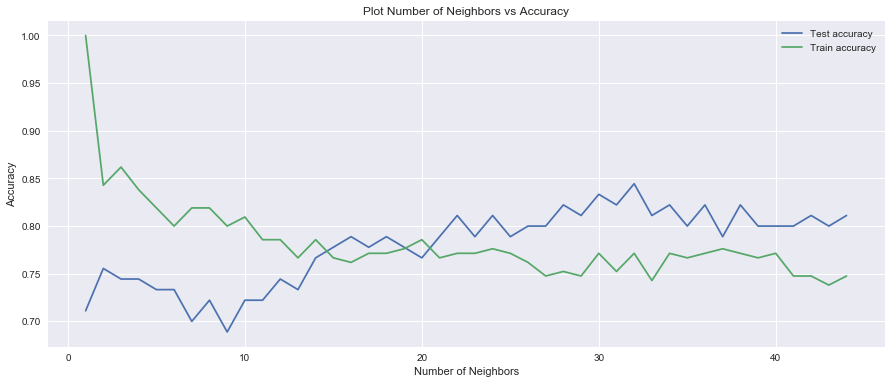

Best test accuracy is 0.844 with K = 32


In [36]:
non = np.arange(1, 45) # number of neighbors to test (k)
accuracy_train = []
accuracy_test = []

# Loop to find how many neighbors (k) to use 
for i, k in enumerate(non):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    
    #get train and test accuracy for comparison
    accuracy_train.append(knn.score(x_train, y_train))
    accuracy_test.append(knn.score(x_test, y_test))

# Plot results
plt.figure(figsize=[15,6])
plt.plot(non, accuracy_test, label = "Test accuracy")
plt.plot(non, accuracy_train, label = "Train accuracy")
plt.legend()
plt.title('Plot Number of Neighbors vs Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()
print("Best test accuracy is {} with K = {}".format(round(np.max(accuracy_test),3),
                                    1+accuracy_test.index(np.max(accuracy_test))))

## Evaluation of KNN using K=32

In [37]:
knn = KNeighborsClassifier(n_neighbors = 32)
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)

print('With KNN (K=32) accuracy is: ',round(knn.score(x_test,y_test),3)) 

With KNN (K=32) accuracy is:  0.844


Accuracy is a measure of the proportion of the predictions which where classified correctly. Here we get an accuracy score of 84.4, which is rather good. If we compare it to the K-Means algorithm with K=2, which got 63.7, it is higher. This makes sense as KNN is a supervised algorithm and learns using the original classes.

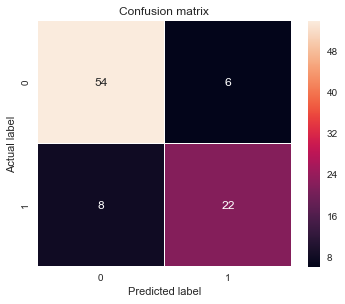

             precision    recall  f1-score   support

          0       0.87      0.90      0.89        60
          1       0.79      0.73      0.76        30

avg / total       0.84      0.84      0.84        90



In [38]:
#create confusion matrix and classification report
confusionMatrix = confusion_matrix(y_test,prediction)
plt.figure(figsize=(5,4))
sns.heatmap(confusionMatrix,annot=True,linewidths=.3)
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test,prediction))

Also for other metrics such as recall (ratio of actual positives our model manages to classify correctly) and precision (how many of the predicted positives are actual positives), we see that KNN performs better than k-Means with K=2. Although the numbers in the confusion matrix are different as we here only have the results from the test set on KNN, compared to the entire dataset which was used for K-means when creating that confusion matrix, we see that KNN manages to get a higher proportion of correct classifications. 

In [39]:
#get ARS
round(metrics.adjusted_rand_score(y_test, prediction),4)

0.4614

In [40]:
#get AMI
round(metrics.adjusted_mutual_info_score(y_test, prediction),4)

0.3238

For both the ARS measure and the AMI measure we see that KNN is able to get a score closer to 1. This tells us that the similarity and agreement between the predicted classes and the actual classes is rather good as it is not too close to 0 and much closer to 1 compared to our results from k-Means. 

# How did the supervised and unsupervised analyses inform each other?

The two analyses inform each other in different ways. Firstly, the k-Means can help us understand the structure in the data without looking at pre-known classifications. The elbow plot told us how many subgroups seem to exist in the data, or how many ubgroups it is meaningful to partition the data into. This can be interesting to know even if we have kown classes as there can be several subgroups which belong to one pre-known class. This was not a clear case in this analysis, but one could for instance imagine how different kinds of values of features (different reasons for spine issues for instance) can result in the same outcome. This is useful to know, as different values of features are relevant for the two subgroups, and as decisions made upon the insights may be different based on this knowledge (for instance different treatmeant for different spine issue subgroup depending on what caused the issues).  <br> 

On the other hand, having the knowledge from performing a supervised analysis, here KNN, can be useful when applying a unsupervised algorithm. Firstly it tells us how well an algorithm which is allowed to learn how to predict an observation's belonging to a certain class by using the already known classifications - is able to perform. This can give us insights into how hard/easy the classes are to separate, and as such how clear the structures in the data could be. In the analyses here, although the KNN performed much better than k-Means in terms of separating the patientClass into two clusters, it's ARS and AMI score showed that it was far from perfect. This told as there were probably some observations which were hard to distinguish. 

# References

1. James, G., Witten, D., & Hastie, T.J. (2014). An Introduction to Statistical Learning with
Applications in R.
2. Transformation statistics https://www.statisticshowto.datasciencecentral.com/transformation-statistics/
3. Ways to Detect and Remove the Outliers https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
4. Clustering performance evaluation (2.3.9) https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
5. KMeans (2.3.2) https://sklearn.org/modules/clustering.html#k-means
6. k-Nearest Neighbors Classifier Scikit Learn Documentation https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
7. KNN Classification using Scikit-learn https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn
8. K-Nearest Neighbors for Machine Learning https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/